# Failing to find a good lagged correlation

A couple of weeks ago I used Forecast Forge to build a forecast for the number of pageviews of the "All I Want for Christmas is You" wikipedia page in the runup to Christmas.

![](https://www.forecastforge.com/files/maria-carey-spike-forecast.png)

> pageviews for the “All I Want For Christmas is You” wikipedia page will peak on 24th December close to 30k

This forecast "looks" good - it has the peak roughly when we'd expect it and the magnitude is comparable with previous years. It passes the smell test, but I am still concerned about whether it predicts the size of the peak correctly. As you can see from the chart, the peak in 2019 was way higher than any of the preceeding years and getting this right is the most important part of my prediction. How can we tell in advance what kind of peak there is going to be?

My hypothesis is that the peak in 2019 was driven by the re-release of the *Merry Christmas* album; something that would have been known about on the 8th November 2019 when the corresponding 2019 forecast would have been made. If I was a Maria Carey expert I would be able to include broader information like this in a regression column; probably by giving each December a mark out of 10 for how much Maria had going on that year.

But I am not a Maria Carey expert so I don't trust my intuition on this; I need some hard data to work with here that might give me an inkling of whether or not she is having a big year.

The first idea that sprang to mind was that it might be possible to use traffic data from other wikipedia pages for this. The challenge is then to find which pages are a leading indicator of Christmas traffic for "All I Want for Christmas is You".

Doing this analysis for *all* pages on Wikipedia would make the challenge more about dealing with big data so instead I first need to select a subset of pages for first analysis. All the pages that link to "All I Want for Christmas is You" seems like a good starting point. You can see a list of these using the [linksto: operator](https://en.wikipedia.org/w/index.php?search=linksto%3A%22All+I+Want+for+Christmas+Is+You%22&title=Special:Search&profile=advanced&fulltext=1&ns0=1) and download the pageview data from the [Massviews tool](https://pageviews.toolforge.org/massviews?project=en.wikipedia.org).

The rest of this post will be me analysing this data and trying (failing!) to use it to make a better forecast.

First let's load the data into python

In [1]:
import pandas as pd

inlinks = pd.read_csv("https://www.forecastforge.com/files/massviews-20150701-20211116.csv",
                      # Need to set this otherwise cloudflare (I think?) 403's the pandas request
                      storage_options = {'User-Agent': 'Pandas!'})
inlinks

Title  2015-07-01  2015-07-02  2015-07-03  \
0                           Justin Bieber       11212       11419       10973   
1                      Millie Bobby Brown           0           0           0   
2                            Mariah Carey        9832       14382       10988   
3                           Fifth Harmony       11649       11674       10864   
4                             Jenna Dewan       13182       26490       21592   
..                                    ...         ...         ...         ...   
628                         Ngayong Pasko           0           0           0   
629  Česko Slovenská SuperStar (season 4)           0           0           0   
630                    Mr. Vocalist X'Mas           0           0           0   
631                 24 Hours (Agnes song)           0           0           0   
632                 We Were Born for This           0           0           0   

     2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
0         10816       10737       11675       14246       13780       12273   
1             0           0           0           0           0           0   
2          9595        9428        9329        8735       13985       10900   
3         10733       11292       12147       12247       12316       11701   
4         16881       14074       16984       12811       11701       10932   
..          ...         ...         ...         ...         ...         ...   
628           0           0           0           0           0           0   
629           0           0           0           0           0           0   
630           0           0           0           0           0           0   
631           0           0           0           0           0           0   
632           0           0           0           0           0           0   

     ...  2021-11-07  2021-11-08  2021-11-09  2021-11-10  2021-11-11  \
0    ...       13804       13002       12540       13343       14681   
1    ...       14229       11248        9497        8314        8197   
2    ...       16638       14650       13315       13851       15706   
3    ...        2385        2071        2169        2334        2098   
4    ...        3598        4857        3929        3307        2906   
..   ...         ...         ...         ...         ...         ...   
628  ...           1           4           1           0           4   
629  ...           4           8           3           4           2   
630  ...           3           2           2           0           0   
631  ...          19          14          15          10           9   
632  ...           3           1           4           4           3   

     2021-11-12  2021-11-13  2021-11-14  2021-11-15  2021-11-16  
0         13842       12980       13267     14624.0     14028.0  
1          8453       12435       11840      9445.0      9979.0  
2         14629       12662       13895     13326.0     10419.0  
3          2151        2244        2091      2104.0      1918.0  
4          2582        2590        3292      5002.0      4402.0  
..          ...         ...         ...         ...         ...  
628           2           0           2         1.0         1.0  
629           2           0           2         1.0         7.0  
630           1           3           0         3.0         1.0  
631           9           8           6        14.0         4.0  
632           4           6           1         3.0        12.0  

[633 rows x 2332 columns]

This looks OK, but I would prefer it if each page was a separate column with a row for each day

In [2]:
inlinks = inlinks.transpose()
## Column names are in the first row
inlinks.columns = inlinks.iloc[0]
## Delete the first row
inlinks = inlinks.drop(["Title"])
inlinks

Title      Justin Bieber Millie Bobby Brown Mariah Carey Fifth Harmony  \
2015-07-01         11212                  0         9832         11649   
2015-07-02         11419                  0        14382         11674   
2015-07-03         10973                  0        10988         10864   
2015-07-04         10816                  0         9595         10733   
2015-07-05         10737                  0         9428         11292   
...                  ...                ...          ...           ...   
2021-11-12         13842               8453        14629          2151   
2021-11-13         12980              12435        12662          2244   
2021-11-14         13267              11840        13895          2091   
2021-11-15       14624.0             9445.0      13326.0        2104.0   
2021-11-16       14028.0             9979.0      10419.0        1918.0   

Title      Jenna Dewan Love Actually Michael Bublé Despacito Tori Kelly  \
2015-07-01       13182          2014          2129         0      12672   
2015-07-02       26490          2409          2628         0      10764   
2015-07-03       21592          2532          2350         0       8501   
2015-07-04       16881          2514          2195         0       7252   
2015-07-05       14074          2445          2344         0       6113   
...                ...           ...           ...       ...        ...   
2021-11-12        2582          4978          7419      1089       1088   
2021-11-13        2590          6175          4041      1181       1272   
2021-11-14        3292          7413          3608       971       2016   
2021-11-15      5002.0        6195.0        3051.0    1066.0     1057.0   
2021-11-16      4402.0        6276.0        3255.0     960.0     1225.0   

Title      Hallelujah (Leonard Cohen song)  ... Colleen Madden  \
2015-07-01                            2091  ...              0   
2015-07-02                            2239  ...              0   
2015-07-03                            2290  ...              0   
2015-07-04                            2643  ...              0   
2015-07-05                            2675  ...              0   
...                                    ...  ...            ...   
2021-11-12                            1801  ...              0   
2021-11-13                            1947  ...              1   
2021-11-14                            2002  ...              0   
2021-11-15                          1709.0  ...            0.0   
2021-11-16                          1524.0  ...            1.0   

Title      List of Tawag ng Tanghalan finalists (season 3)  \
2015-07-01                                               0   
2015-07-02                                               0   
2015-07-03                                               0   
2015-07-04                                               0   
2015-07-05                                               0   
...                                                    ...   
2021-11-12                                               0   
2021-11-13                                               1   
2021-11-14                                               3   
2021-11-15                                             3.0   
2021-11-16                                             NaN   

Title      List of top 10 singles for 2018 in Australia  \
2015-07-01                                            0   
2015-07-02                                            0   
2015-07-03                                            0   
2015-07-04                                            0   
2015-07-05                                            0   
...                                                 ...   
2021-11-12                                            1   
2021-11-13                                            1   
2021-11-14                                            4   
2021-11-15                                          2.0   
2021-11-16             

Much better!

Now load the "All I Want for Christmas is You" pageview data

In [3]:
alliwant = pd.read_csv("https://www.forecastforge.com/files/pageviews-20150701-20211108.csv",
                      storage_options = {'User-Agent': 'Pandas!'})
alliwant

Date  All I Want for Christmas Is You
0     2015-07-01                              189
1     2015-07-02                              248
2     2015-07-03                              179
3     2015-07-04                              208
4     2015-07-05                              245
...          ...                              ...
2318  2021-11-04                             4103
2319  2021-11-05                             3556
2320  2021-11-06                             3192
2321  2021-11-07                             3046
2322  2021-11-08                             2760

[2323 rows x 2 columns]

Match the timeseries up by joining the dataframes together

In [4]:
## Default is inner join so rows match up
all_series = alliwant.join(inlinks, on="Date")
all_series = all_series.set_index("Date")
all_series

All I Want for Christmas Is You Justin Bieber Millie Bobby Brown  \
Date                                                                           
2015-07-01                              189         11212                  0   
2015-07-02                              248         11419                  0   
2015-07-03                              179         10973                  0   
2015-07-04                              208         10816                  0   
2015-07-05                              245         10737                  0   
...                                     ...           ...                ...   
2021-11-04                             4103         12832               8495   
2021-11-05                             3556         12473               7724   
2021-11-06                             3192         13273              11944   
2021-11-07                             3046         13804              14229   
2021-11-08                             2760         13002              11248   

           Mariah Carey Fifth Harmony Jenna Dewan Love Actually Michael Bublé  \
Date                                                                            
2015-07-01         9832         11649       13182          2014          2129   
2015-07-02        14382         11674       26490          2409          2628   
2015-07-03        10988         10864       21592          2532          2350   
2015-07-04         9595         10733       16881          2514          2195   
2015-07-05         9428         11292       14074          2445          2344   
...                 ...           ...         ...           ...           ...   
2021-11-04        18005          2393        3147          2783          2875   
2021-11-05        18080          2206        2789          4056          2925   
2021-11-06        16802          2231        3408          5880          2740   
2021-11-07        16638          2385        3598          6717          2705   
2021-11-08        14650          2071        4857          5436          2427   

           Despacito Tori Kelly  ... Colleen Madden  \
Date                             ...                  
2015-07-01         0      12672  ...              0   
2015-07-02         0      10764  ...              0   
2015-07-03         0       8501  ...              0   
2015-07-04         0       7252  ...              0   
2015-07-05         0       6113  ...              0   
...              ...        ...  ...            ...   
2021-11-04       973       1525  ...              0   
2021-11-05       992       1341  ...              3   
2021-11-06      1067       1322  ...              0   
2021-11-07      1194       1269  ...              1   
2021-11-08       956       1073  ...              4   

           List of Tawag ng Tanghalan finalists (season 3)  \
Date                                                         
2015-07-01                                               0   
2015-07-02                                               0   
2015-07-03                                               0   
2015-07-04                                               0   
2015-07-05                                               0   
...                                                    ...   
2021-11-04                                               1   
2021-11-05                                               0   
2021-11-06                                               2   
2021-11-07                                               4   
2021-11-08                                               1   

           List of top 10 singles for 2018 in Australia  \
Date                                                      
2015-07-01                                            0   
2015-07-02                                            0   
2015-07-03                                            0   
2015-07-04                                            0   
2015-07-05                              

Eventually I want to run some kind of regression on the lagged timeseries; and I want to easily be able to tell which regression coefficients are important and which are not. So I am going to normalise all the data so it has mean of `0` and standard deviation of `1`

In [5]:
normalised=(all_series-all_series.mean())/all_series.std()
normalised

All I Want for Christmas Is You Justin Bieber Millie Bobby Brown  \
Date                                                                           
2015-07-01                        -0.360837     -0.666008           -0.60886   
2015-07-02                        -0.343616     -0.646519           -0.60886   
2015-07-03                        -0.363756      -0.68851           -0.60886   
2015-07-04                        -0.355291     -0.703292           -0.60886   
2015-07-05                        -0.344492     -0.710729           -0.60886   
...                                     ...           ...                ...   
2021-11-04                         0.781595     -0.513486            -0.1901   
2021-11-05                         0.621934     -0.547286          -0.228106   
2021-11-06                         0.515689     -0.471966          -0.020082   
2021-11-07                         0.473074     -0.421973           0.092557   
2021-11-08                         0.389595     -0.497481          -0.054391   

           Mariah Carey Fifth Harmony Jenna Dewan Love Actually Michael Bublé  \
Date                                                                            
2015-07-01    -0.136275      0.833743    0.602052      -0.38695     -0.350378   
2015-07-02     0.180788      0.837845    1.721202     -0.329304     -0.261714   
2015-07-03     -0.05572      0.704938    1.309299     -0.311353      -0.31111   
2015-07-04     -0.15279      0.683444    0.913123      -0.31398     -0.338651   
2015-07-05    -0.164428      0.775165    0.677065      -0.32405     -0.312176   
...                 ...           ...         ...           ...           ...   
2021-11-04     0.433254     -0.684997   -0.241852     -0.274723     -0.217826   
2021-11-05     0.438481     -0.715681   -0.271958     -0.088942     -0.208942   
2021-11-06     0.349424     -0.711579   -0.219903      0.177251     -0.241814   
2021-11-07     0.337996      -0.68631   -0.203925      0.299402     -0.248033   
2021-11-08     0.199464     -0.737832   -0.098048      0.112454     -0.297429   

           Despacito Tori Kelly  ... Colleen Madden  \
Date                             ...                  
2015-07-01 -0.572981    1.37151  ...      -0.382595   
2015-07-02 -0.572981   1.083843  ...      -0.382595   
2015-07-03 -0.572981   0.742653  ...      -0.382595   
2015-07-04 -0.572981   0.554343  ...      -0.382595   
2015-07-05 -0.572981   0.382617  ...      -0.382595   
...              ...        ...  ...            ...   
2021-11-04 -0.424959   -0.30911  ...      -0.382595   
2021-11-05 -0.422069  -0.336852  ...       2.077097   
2021-11-06 -0.410659  -0.339716  ...      -0.382595   
2021-11-07 -0.391339  -0.347707  ...       0.437302   
2021-11-08 -0.427545  -0.377258  ...       2.896995   

           List of Tawag ng Tanghalan finalists (season 3)  \
Date                                                         
2015-07-01                                       -0.361893   
2015-07-02                                       -0.361893   
2015-07-03                                       -0.361893   
2015-07-04                                       -0.361893   
2015-07-05                                       -0.361893   
...                                                    ...   
2021-11-04                                        0.478784   
2021-11-05                                       -0.361893   
2021-11-06                                         1.31946   
2021-11-07                                        3.000813   
2021-11-08                                        0.478784   

           List of top 10 singles for 2018 in Australia  \
Date                                                      
2015-07-01                                    -0.156449   
2015-07-02                                    -0.156449   
2015-07-03                                    -0.156449   
2015-07-04                                    -0.156449   
2015-07-05                              

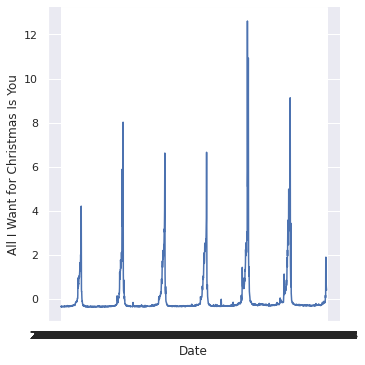

In [6]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(12,6)})
sns.relplot(x="Date",y="All I Want for Christmas Is You", kind="line", data=normalised)

The "All I Want for Christmas is You" data looks how it should. 

Eventually I want to start to use the pageview data from the in-linking pages to make a better forecast for this. There are 633 of these pages but I will also need to look at whether a page is a leading indicator by 30 days, 50 days etc. This quickly multiplies out to be **a lot** of potential regressor columns; I am nervous about chucking this amount of data at a regression algorithm and hoping it can figure out what is and isn't important.

There are certainly situations where this would be a good approach but for this specific problem I don't like it. There might be 2323 rows of data but there are only six Christmas peaks - and if I reserve one of them for testing then that only leaves five for training. This means there is a big risk of overfitting and the more regression variables I throw into the mix, the bigger this risk.

My plan here is to follow a two step process:

1. Filter out a lot of the regression variables based on correlation value
2. Setup the forecasting model so that it will only use a small number of them

There are a few different ways of doing step 2. Tensorflow supports "Structural Time Series" (more on this shortly) with a [Sparse Linear Regression](https://www.tensorflow.org/probability/api_docs/python/tfp/sts/SparseLinearRegression) component.

> SparseLinearRegression uses a parameterization of a Horseshoe prior to encode the assumption that many of the weights are zero, i.e., many of the covariate time series are irrelevant

Which sounds pretty close to what I want so let's go with that for now.

Rather than diving straight into the deep end let's start by making a simpler model so we can verify it works

In [7]:
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf

## Forgetting this line is my number one cause of mysterf tf errors that I can't figure out
tf.enable_v2_behavior()

The "structure" in a structural timeseries describes how the timeseries evolves given certain parameters. For example, we might model the value at day `t+1` as the value at day `t` plus a small amount of random noise. This is a "random walk" model and it can actually work pretty well for predicting things only 1 day ahead.

The parameters are estimated from historical data; in the above example the parameter to estimate is the variance of the random noise.

The first model I want to try is a bit more complicated than that. It is similar to how Forecast Forge works behind the scenes. There are three components:

+ Two seasonalities; weekly and annual
+ A trend component


The trend component looks a bit similar to the first random walk example:
```
level[t] = level[t-1] + slope[t-1] + Normal(0., level_scale)
slope[t] = slope[t-1] + Normal(0., slope_scale)
```
The main difference is that there is both a `level` and a `slope` both random walking around. This means that the model is slower to "change direction" than a random walk; if the slope is large and positive then it will take a few days for it to become negative and start trending the other way.

The weekly seasonality component will estimate an effect for each day. This is the same approach to seasonality that Tom Capper uses in his [Google Sheets template on Moz](https://moz.com/blog/seo-forecasting-in-google-sheets).

The annual seasonality component is designed to be *smoother* than that. This is actually a weakness when forecasting "All I Want for Christmas is You" pageviews because the data is so "spikey" but I have picked this for three reasons:

1. I don't want to estimate 12 different monthly effects because the peak in pageviews is concentrated at one part of December. Adding an average effect for the whole month to whatever weekly seasonality there is won't capture the 7 days before Christmas very well
2. Estimating an effect for each of 365 days slows down the model fit quite a lot and eats RAM like it is going out of fashion. This way of modelling things also ignores any smoothness there might be in the data (e.g. the value for November 23rd is likely to be close to the values for November 22nd and 24th)
3. This is most similar to what the Forecast Forge algorithm does which makes the forecasts more comparable

In [8]:
def build_model(observed_time_series):
  trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)
  weekly = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series, name="week")
  annual = tfp.sts.SmoothSeasonal(
      period=365, frequency_multipliers=[1, 2, 3, 4, 5, 6])
  # The actual prediction is the sum of the above three components
  model = tfp.sts.Sum([trend, weekly, annual], observed_time_series=observed_time_series)
  return model

Let's forecast for Christmas 2020 and see what it looks like against the actuals.

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


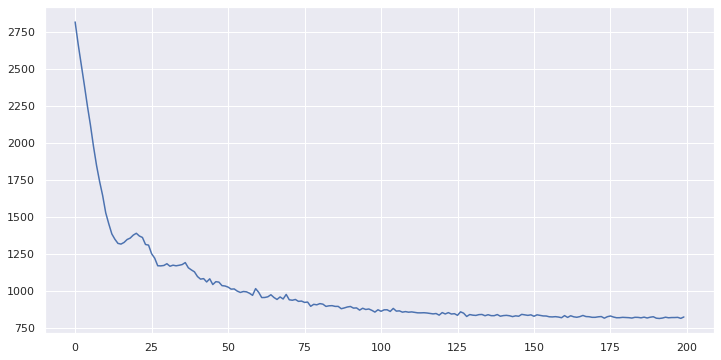

In [9]:
observed = normalised[normalised.index<"2020-11-09"]["All I Want for Christmas Is You"]
observed = list(observed)

model = build_model(observed)

# The below is mostly tensorflow voodoo
# The output will be a loss curve plot; we want to see that this converges before proceeding
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)

num_variational_steps = 200

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(
        observed_time_series=observed),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples = variational_posteriors.sample(100)

The model converges (yay!) so we can use the parameter samples from the posterior to get the forecast values

In [10]:
forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=observed,
    parameter_samples=q_samples,
    num_steps_forecast=53)

forecast_mean, forecast_scale = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0])

Quick inspection of the forecast_mean data. We want to see values somewhere between 4 and 8 later in the series

In [11]:
forecast_mean

array([0.35289314, 0.46619806, 0.48649132, 0.4791094 , 0.55845815,
       0.63580596, 0.7344554 , 0.8415572 , 0.9938936 , 1.0518934 ,
       1.0805393 , 1.1938901 , 1.3028748 , 1.4304701 , 1.5635145 ,
       1.7384964 , 1.815573  , 1.8594788 , 1.9840505 , 2.1000252 ,
       2.2302155 , 2.361333  , 2.5297706 , 2.5956268 , 2.6236136 ,
       2.7275822 , 2.8183236 , 2.9187396 , 3.0156708 , 3.1456726 ,
       3.1690443 , 3.1507301 , 3.2048495 , 3.2424893 , 3.286877  ,
       3.3252015 , 3.3943956 , 3.3551486 , 3.2728195 , 3.261949  ,
       3.2340572 , 3.2128124 , 3.1858494 , 3.1905372 , 3.0880094 ,
       2.9440494 , 2.8736162 , 2.788633  , 2.7131534 , 2.6351662 ,
       2.5923865 , 2.4462488 , 2.2628186 ], dtype=float32)

Hmmm, possible a little low.

Pad these forecasted values out so we can compare them with the actuals in a plot

<AxesSubplot:xlabel='Day'>

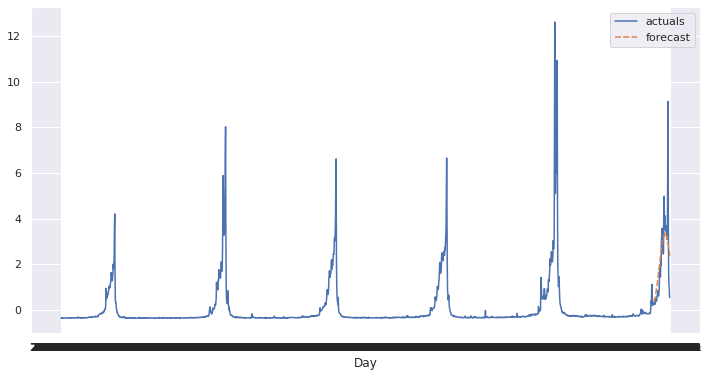

In [12]:
padded_forecast = np.pad(forecast_mean,(len(observed),0),constant_values=(np.NaN,))

forecast_df = pd.DataFrame({"forecast":padded_forecast
                           })
forecast_df["actuals"] = list(normalised["All I Want for Christmas Is You"] [:forecast_df.shape[0]])
forecast_df.index = normalised.index[:forecast_df.shape[0]]
forecast_df.index.name = "Day"
forecast_df = forecast_df[["actuals", "forecast"]]

sns.lineplot(data=forecast_df)

Not bad! It misses the big peaks but that is ok for now because the model doesn't have anything in it to account for them.

Now back to doing some data-munging in preparation for the lagged regression.

First extend the index on the dataframe into the future - this is so there is "space" for the lagged regressors to go into. There is probably a better way of doing this, LMK if you know what it is.

In [13]:
from datetime import date
old_ix = pd.date_range(start=date(2015, 7, 1), end=date(2021, 11, 8), freq='D')
extended_ix = pd.date_range(start=date(2015, 7, 1), end=date(2021, 12, 31), freq='D')
normalised.index = old_ix
normalised = normalised.reindex(extended_ix)

The absolute minimum amount of lag we can consider is 53 days; this means the value on November 8th will tell us a bit about what happens on New Year's Eve. I've decided the maximum to look at is 83 days; looking back earlier than October probably won't give that much extra information.

So now make a dataframe with every page lagged between 53 and 83 days:

In [14]:
shifted = None
for i in range(53,83):
    x = normalised.drop(columns="All I Want for Christmas Is You").shift(periods=i).add_suffix("_"+str(i))
    if shifted is None:
        shifted = x
    else:
        shifted = pd.concat([shifted,x], axis=1)

shifted.columns

Index(['Justin Bieber_53', 'Millie Bobby Brown_53', 'Mariah Carey_53',
       'Fifth Harmony_53', 'Jenna Dewan_53', 'Love Actually_53',
       'Michael Bublé_53', 'Despacito_53', 'Tori Kelly_53',
       'Hallelujah (Leonard Cohen song)_53',
       ...
       'Colleen Madden_82',
       'List of Tawag ng Tanghalan finalists (season 3)_82',
       'List of top 10 singles for 2018 in Australia_82',
       'The Masked Singer (Bulgarian season 1)_82',
       'List of Billboard Global 200 number ones of 2021_82',
       'Ngayong Pasko_82', 'Česko Slovenská SuperStar (season 4)_82',
       'Mr. Vocalist X'Mas_82', '24 Hours (Agnes song)_82',
       'We Were Born for This_82'],
      dtype='object', length=18990)

`18990` is a lot of columns. Let's reduce that number down by seeing which have a statistically significant correlation with "All I Want for Christmas is You"

In [15]:
from scipy.stats import pearsonr

sig_cols = []
for i in shifted.columns:
    nas = np.logical_or(np.isnan(normalised["All I Want for Christmas Is You"].values), 
                        np.isnan(shifted[i].values.astype("float")))
    
    corr, pval = pearsonr(normalised["All I Want for Christmas Is You"].values[~nas], 
                          shifted[i].values[~nas]
                         )
    if(pval < 0.05):
      sig_cols.append({"col":i, "corr":corr, "p":pval})

# View the top ten    
sig_cols.sort(key=lambda x: -abs(x['corr']))
sig_cols[:10]

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[{'col': 'Tawag ng Tanghalan (season 3, quarter I)_80',
  'corr': 0.42718188064663565,
  'p': 3.524046455470085e-100},
 {'col': 'Tawag ng Tanghalan (season 3)_80',
  'corr': 0.41963677515784387,
  'p': 2.2040219582815046e-96},
 {'col': 'Tawag ng Tanghalan (season 3)_81',
  'corr': 0.4151538500141587,
  'p': 3.9297134847417186e-94},
 {'col': 'Tawag ng Tanghalan (season 3)_82',
  'corr': 0.41496413323530373,
  'p': 5.348570466557383e-94},
 {'col': 'Tawag ng Tanghalan (season 3, quarter I)_81',
  'corr': 0.38587368756325663,
  'p': 1.6532525769584053e-80},
 {'col': 'Tawag ng Tanghalan (season 3, quarter I)_79',
  'corr': 0.37752700745584056,
  'p': 6.1489592197905055e-77},
 {'col': 'Tawag ng Tanghalan (season 3, quarter I)_82',
  'corr': 0.36852002750662144,
  'p': 4.9533722974120236e-73},
 {'col': 'The X Factor: Celebrity_59',
  'corr': 0.34727695650499074,
  'p': 3.603730969714107e-65},
 {'col': 'Tawag ng Tanghalan (season 3)_79',
  'corr': 0.344126527727554,
  'p': 2.114127129858737e-6

"Tawag ng Tanghalan" is a Philippine singing competition which I'm guessing is similar to the X Factor (also listed in the top 10). It seems like these competitions start their TV runs in late Autumn and interest builds through until the final before Christmas - maybe so the winner can have a shot at a Christmas number one.

This means that interest and pageviews to their wikipedia pages start increasing through November so the lagged correlation with "All I Want for Christmas is You" appears strong. I'm guessing that "All I Want for Christmas is You" is also sung in the later stages of these competitions which is why the wikipedia pages are linked.

Worryingly, none of this is saying anything about what Maria Carey is doing in November and wikipedia pages for new seasons of Tawag ng Tanghalan won't be included in our data set but let's plow on regardless.

In [16]:
def build_regressor_model(observed_time_series, regressors):
  trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)
  weekly = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series, name="week")
  annual = tfp.sts.SmoothSeasonal(
      period=365, frequency_multipliers=[1, 2, 3, 4, 5, 6])
  regressors = tfp.sts.SparseLinearRegression(
       design_matrix=regressors, weights_prior_scale=0.01
  )
  model = tfp.sts.Sum([trend, weekly, annual, regressors], observed_time_series=observed_time_series)
  return model

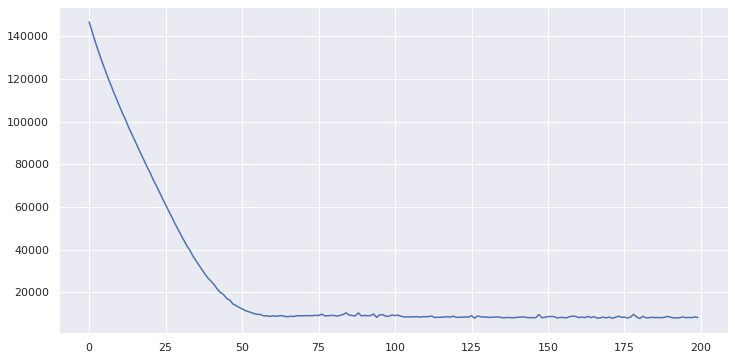

In [17]:
training_regressors = shifted[[x['col'] for x in sig_cols]].to_numpy(na_value=0).astype("float32")

regressor_model = build_regressor_model(observed, training_regressors)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=regressor_model)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=regressor_model.joint_log_prob(
        observed_time_series=observed),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples = variational_posteriors.sample(100)

Now make the forecast

In [18]:
forecast_dist = tfp.sts.forecast(
    regressor_model,
    observed_time_series=observed,
    parameter_samples=q_samples,
    num_steps_forecast=53)

In [19]:
forecast_mean, forecast_scale = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0])

In [20]:
forecast_mean

array([0.3419128 , 0.16032058, 0.15885748, 0.1694471 , 0.17209485,
       0.24001464, 0.30079925, 0.23198693, 0.2288272 , 0.30739444,
       0.2748402 , 0.27468073, 0.2854338 , 0.3390003 , 0.43987024,
       0.4561404 , 0.41528323, 0.5061559 , 0.5395754 , 0.5807379 ,
       0.65537524, 0.74345917, 0.6702833 , 0.6577884 , 0.7820074 ,
       0.9250628 , 0.98716795, 0.97071433, 0.96333086, 1.0289012 ,
       1.0218781 , 1.0453612 , 1.2554653 , 1.3225553 , 1.4090129 ,
       1.3831987 , 1.2706091 , 1.4852198 , 1.4680619 , 1.493119  ,
       1.4223785 , 1.4672687 , 1.3933413 , 1.3527845 , 1.2680241 ,
       1.389934  , 1.2610297 , 1.179503  , 1.1058247 , 0.96355927,
       0.806806  , 0.78724074, 0.7621913 ], dtype=float32)

This seems way worse; peak value for the first forecast was `3.68` compared with `2.69` here

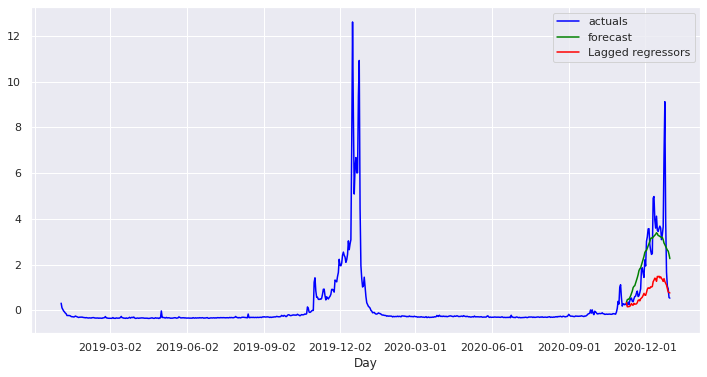

In [21]:
padded_forecast = np.pad(forecast_mean,(len(observed),0),constant_values=(np.NaN,))
forecast_df['Lagged regressors'] = padded_forecast
ax = sns.lineplot(data=forecast_df.tail(730), dashes=False, palette=["blue","green","red"], sizes=[1,10,10])
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.show()

This is textbook overfitting :-(

Regressors that were predictive in December 2019 do not work so well in 2020 and the model has learned to rely more on the regressors than the seasonal components.

Let's analyse this in a little more detail by looking at the regression coefficients

In [22]:
regs = q_samples['SparseLinearRegression/_weights_noncentered'].numpy().mean(axis=0)
from scipy import stats
stats.describe(regs)

DescribeResult(nobs=9766, minmax=(-3.6937814, 5.5515313), mean=0.0075476845, variance=0.11523925, skewness=2.4852867126464844, kurtosis=42.284171718810875)

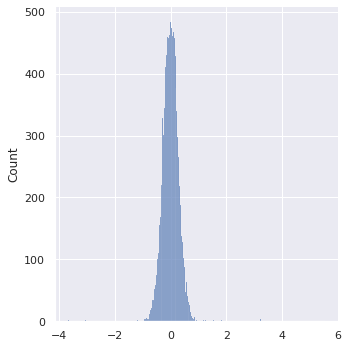

In [23]:
sns.displot(regs)

These are not what I expected! It is true that the regression coefficiants are tightly distributed around zero, but I was expecting it to be more obvious which of them were relevant and which weren't. I think the `SparseLinearRegression` hasn't worked the way that I wanted it to.

So to sum up there are two main problems here, they are kind of linked but each could happen alone too:

1. I chucked a load of data at an algorithm expecting it to be able to figure out what was and wasn't important
2. The result was overfitted on the training set

Can I do better by manually choosing regressors?

Let's look at only various lags for the Maria Carey page.

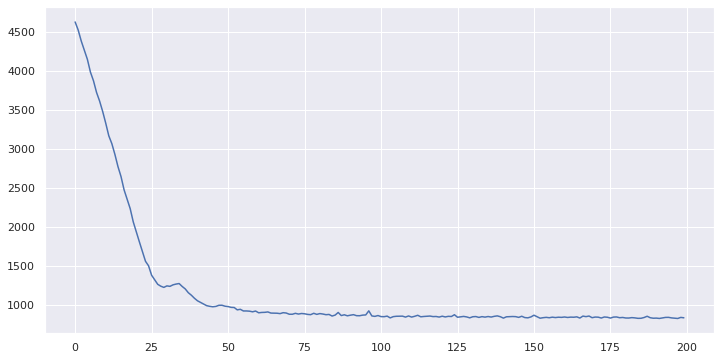

In [24]:
cols = [col for col in shifted if col.startswith("Mariah Carey_")]
shifted_mariah = shifted[cols]

training_regressors = shifted_mariah.to_numpy(na_value=0).astype("float32")

regressor_model = build_regressor_model(observed, training_regressors)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=regressor_model)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=regressor_model.joint_log_prob(
        observed_time_series=observed),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples = variational_posteriors.sample(100)

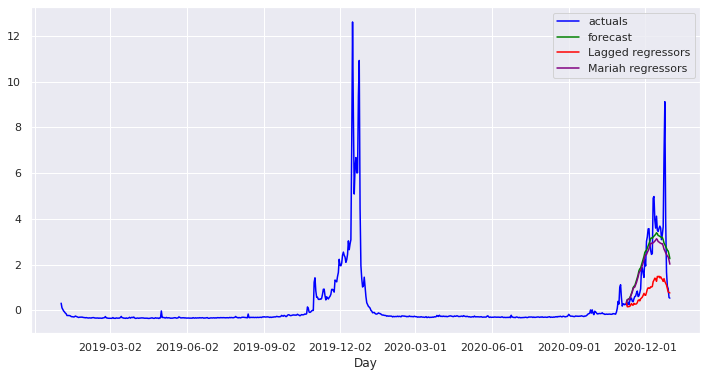

In [25]:
forecast_dist = tfp.sts.forecast(
    regressor_model,
    observed_time_series=observed,
    parameter_samples=q_samples,
    num_steps_forecast=53)

forecast_mean, forecast_scale = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0])

padded_forecast = np.pad(forecast_mean,(len(observed),0),constant_values=(np.NaN,))
forecast_df['Mariah regressors'] = padded_forecast
ax = sns.lineplot(data=forecast_df.tail(730), dashes=False
                  , palette=["blue","green","red","purple"]
                  , sizes=[1,10,10])
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.show()

The result isn't very different to the first attempt forecast; it looks like pageviews for "Mariah Carey" in November don't tell you very much about what is going to happen in December.

I'm going to leave it here for the day, I hope this post has demonstrated two things:

1. This stuff is hard. Being able to use fancy tensorflow models doesn't necessarily make things any easier
2. I don't know enough about All I Want for Christmas is You to really drive this forward (or else it is just hard - see point 1)